### Forecast de demanda: Facturapp

### ✅ Prophet

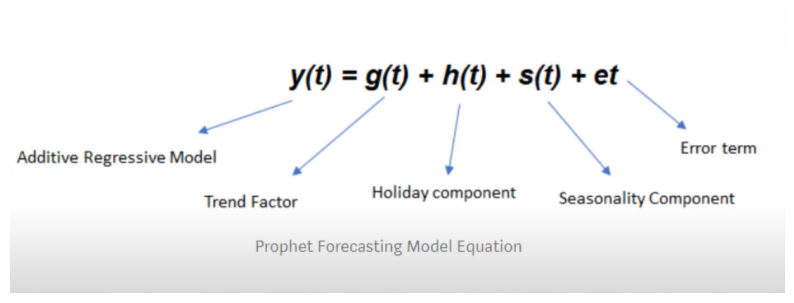

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cargar la imagen
img = mpimg.imread('C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/04_Prophet/Prophet forecasting model equation.PNG')

# Mostrar la imagen
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Para ocultar los ejes
plt.show()


##### Datos

In [96]:
import warnings
warnings.simplefilter("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [97]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [98]:
# Crear la tabla agregada
df_prophet = ventas_df.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Renombramos variables para que prophet tome como input
df = df_prophet.rename(columns={'fecha_venta': 'ds', 'cantidad_ventas_producto': 'y'})
df.head()

,ds,y
0,2022-04-16,39.000
1,2022-04-17,165.640
2,2022-04-18,2235.130
3,2022-04-19,1167.624
4,2022-04-20,1734.857


In [87]:
import plotly.express as px

px.line(df, x='ds', y='y',title="Forecast de demanda Facturapp")

#### Variables exógenas

In [100]:
# Asegúrate de que la columna 'ds' sea de tipo datetime
df['ds'] = pd.to_datetime(df['ds'])

# Variables exógenes: Crear la nueva columna 'end_of_day' y 'end_of_month'
df['end_of_week'] = df['ds'].apply(lambda x: 1 if x.dayofweek == 6 else 0)
df['end_of_month'] = df['ds'].apply(lambda x: 1 if x.is_month_end else 0)

In [101]:
df.head()

,ds,y,end_of_week,end_of_month
0,2022-04-16,39.000,0,0
1,2022-04-17,165.640,1,0
2,2022-04-18,2235.130,0,0
3,2022-04-19,1167.624,0,0
4,2022-04-20,1734.857,0,0


#### Compare models

##### Test 1

In [11]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from prophet import Prophet

def compare_models_with_table(df):
    # Función para calcular y devolver MSE y RMSE
    def evaluate_model(forecast, actuals):
        mse = mean_squared_error(actuals, forecast)
        rmse = np.sqrt(mse)
        return mse, rmse
    
    # Lista para almacenar los resultados
    results = []
    
    # Modelo base con todas las estacionalidades activadas y días festivos
    m1 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.05
    )
    m1.add_country_holidays(country_name='UY')
    m1.fit(df)
    future1 = m1.make_future_dataframe(periods=60)
    forecast1 = m1.predict(future1)
    mse1, rmse1 = evaluate_model(forecast1['yhat'][:len(df)], df['y'])
    results.append(['Estacionalidad completa con festivos', mse1, rmse1])

    # Modelo sin estacionalidad diaria
    m2 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05
    )
    m2.add_country_holidays(country_name='UY')
    m2.fit(df)
    future2 = m2.make_future_dataframe(periods=60)
    forecast2 = m2.predict(future2)
    mse2, rmse2 = evaluate_model(forecast2['yhat'][:len(df)], df['y'])
    results.append(['Sin estacionalidad diaria', mse2, rmse2])

    # Modelo sin estacionalidad anual
    m3 = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.05
    )
    m3.add_country_holidays(country_name='UY')
    m3.fit(df)
    future3 = m3.make_future_dataframe(periods=60)
    forecast3 = m3.predict(future3)
    mse3, rmse3 = evaluate_model(forecast3['yhat'][:len(df)], df['y'])
    results.append(['Sin estacionalidad anual', mse3, rmse3])

    # Modelo con rango de puntos de cambio ajustado
    m4 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_range=0.6  # Cambia el rango de puntos de cambio al 60%
    )
    m4.add_country_holidays(country_name='UY')
    m4.fit(df)
    future4 = m4.make_future_dataframe(periods=60)
    forecast4 = m4.predict(future4)
    mse4, rmse4 = evaluate_model(forecast4['yhat'][:len(df)], df['y'])
    results.append(['Rango de puntos de cambio 60%', mse4, rmse4])

    # Modelo con escalado de puntos de cambio más flexible
    m5 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.5  # Hacer más flexible el modelo (puntos de cambio más grandes)
    )
    m5.add_country_holidays(country_name='UY')
    m5.fit(df)
    future5 = m5.make_future_dataframe(periods=60)
    forecast5 = m5.predict(future5)
    mse5, rmse5 = evaluate_model(forecast5['yhat'][:len(df)], df['y'])
    results.append(['Escalado flexible (changepoint_prior_scale=0.5)', mse5, rmse5])

    # Modelo con escalado de puntos de cambio más rígido
    m6 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.01  # Hacer más rígido el modelo (puntos de cambio más pequeños)
    )
    m6.add_country_holidays(country_name='UY')
    m6.fit(df)
    future6 = m6.make_future_dataframe(periods=60)
    forecast6 = m6.predict(future6)
    mse6, rmse6 = evaluate_model(forecast6['yhat'][:len(df)], df['y'])
    results.append(['Escalado rígido (changepoint_prior_scale=0.01)', mse6, rmse6])

    # Crear DataFrame para almacenar los resultados
    results_df = pd.DataFrame(results, columns=['Modelo', 'MSE', 'RMSE'])

    # Ordenar por MSE (menor es mejor)
    results_df = results_df.sort_values(by=['MSE'])

    return results_df

# Ejecutar la comparación y generar la tabla
compare_models_with_table(df)


23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:12 - cmdstanpy - INFO - Chain [1] start processing
23:14:12 - cmdstanpy - INFO - Chain [1] done processing
23:14:13 - cmdstanpy - INFO - Chain [1] start processing
23:14:13 - cmdstanpy - INFO - Chain [1] done processing
23:14:13 - cmdstanpy - INFO - Chain [1] start processing
23:14:13 - cmdstanpy - INFO - Chain [1] done processing
23:14:14 - cmdstanpy - INFO - Chain [1] start processing
23:14:14 - cmdstanpy - INFO - Chain [1] done processing


,Modelo,MSE,RMSE
4,Escalado flexible (changepoint_prior_scale=0.5),434136.020581,658.889991
1,Sin estacionalidad diaria,440148.755857,663.437078
0,Estacionalidad completa con festivos,440230.751709,663.498871
3,Rango de puntos de cambio 60%,441670.201331,664.582727
2,Sin estacionalidad anual,461214.632257,679.127847
5,Escalado rígido (changepoint_prior_scale=0.01),501194.399987,707.950846


##### Test 2

In [19]:
import itertools
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Función para calcular RMSE
def evaluate_model(forecast, actuals):
    mse = mean_squared_error(actuals, forecast)
    rmse = np.sqrt(mse)
    return mse, rmse

# Función para realizar Grid Search en Prophet con todos los parámetros posibles
def prophet_grid_search(df, param_grid):
    # Lista para almacenar los resultados
    results = []
    
    # Generar todas las combinaciones posibles de los parámetros
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    
    # Iterar sobre cada combinación de parámetros
    for params in all_params:
        # Crear el modelo Prophet con los parámetros actuales
        m = Prophet(
            growth=params['growth'],
            changepoints=params['changepoints'],
            n_changepoints=params['n_changepoints'],
            changepoint_range=params['changepoint_range'],
            yearly_seasonality=params['yearly_seasonality'],
            weekly_seasonality=params['weekly_seasonality'],
            daily_seasonality=params['daily_seasonality'],
            holidays=params['holidays'],
            seasonality_mode=params['seasonality_mode'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'],
            changepoint_prior_scale=params['changepoint_prior_scale'],
            mcmc_samples=params['mcmc_samples'],
            interval_width=params['interval_width'],
            uncertainty_samples=params['uncertainty_samples'],
            stan_backend=params['stan_backend']
        )
        
        if params.get('country_holidays'):
            m.add_country_holidays(country_name=params['country_holidays'])
        
        # Entrenar el modelo
        m.fit(df)
        
        # Hacer predicciones
        future = m.make_future_dataframe(periods=60)
        forecast = m.predict(future)
        
        # Evaluar el modelo (MSE y RMSE)
        mse, rmse = evaluate_model(forecast['yhat'][:len(df)], df['y'])
        
        # Guardar los resultados (parámetros, MSE y RMSE)
        results.append((params, mse, rmse))
    
    # Ordenar los resultados por RMSE (menor es mejor)
    results = sorted(results, key=lambda x: x[2])  # Ordenar por RMSE
    
    # Mostrar la mejor combinación de parámetros
    best_params, best_mse, best_rmse = results[0]
    print(f"Mejor combinación de parámetros: {best_params}")
    print(f"Mejor MSE: {best_mse}")
    print(f"Mejor RMSE: {best_rmse}")
    
    return best_params, best_mse, best_rmse

# Definir el rango de hiperparámetros a probar (grid search)
param_grid = {
    'growth': ['linear'],  # Tipo de tendencia
    'changepoints': [None],  # Dejar Prophet detectar los puntos de cambio automáticamente
    'n_changepoints': [25],  # Número de puntos de cambio
    'changepoint_range': [0.8],  # Proporción del historial en el que se detectan los puntos de cambio
    'yearly_seasonality': [True],  # Estacionalidad anual
    'weekly_seasonality': [True],  # Estacionalidad semanal
    'daily_seasonality': [True],  # Estacionalidad diaria
    'holidays': [None],  # Usar un DataFrame de días festivos si es necesario
    'seasonality_mode': ['multiplicative'],  # Modo de estacionalidad
    'seasonality_prior_scale': [10.0],  # Regularización de la estacionalidad
    'holidays_prior_scale': [10.0],  # Regularización de los efectos de días festivos
    'changepoint_prior_scale': [0.5],  # Regularización de los puntos de cambio
    'mcmc_samples': [0],  # No se usa MCMC en la mayoría de los casos
    'interval_width': [0.95],  # Intervalo de incertidumbre
    'uncertainty_samples': [1000],  # Número de muestras de incertidumbre posterior
    'stan_backend': [None],  # Mantener el backend predeterminado
    'country_holidays': ['UY']  # Probar con días festivos de Uruguay
}

# Ejecutar la búsqueda de hiperparámetros con el dataset
best_params, best_mse, best_rmse = prophet_grid_search(df, param_grid)

#Mejor combinación de parámetros: {'growth': 'linear', 'changepoints': None, 'n_changepoints': 25, 'changepoint_range': 0.8, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'daily_seasonality': True, 'holidays': None, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'changepoint_prior_scale': 0.5, 'mcmc_samples': 0, 'interval_width': 0.95, 'uncertainty_samples': 1000, 'stan_backend': None, 'country_holidays': 'UY'}
#Mejor MSE: 432678.13984910503
#Mejor RMSE: 657.7827451743509

12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:15 - cmdstanpy - INFO - Chain [1] done processing


Mejor combinación de parámetros: {'growth': 'linear', 'changepoints': None, 'n_changepoints': 25, 'changepoint_range': 0.8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'holidays': None, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'changepoint_prior_scale': 0.5, 'mcmc_samples': 0, 'interval_width': 0.95, 'uncertainty_samples': 1000, 'stan_backend': None, 'country_holidays': 'UY'}
Mejor MSE: 432678.13984910503
Mejor RMSE: 657.7827451743509


##### Feature importance

13:52:42 - cmdstanpy - INFO - Chain [1] start processing
13:52:43 - cmdstanpy - INFO - Chain [1] done processing


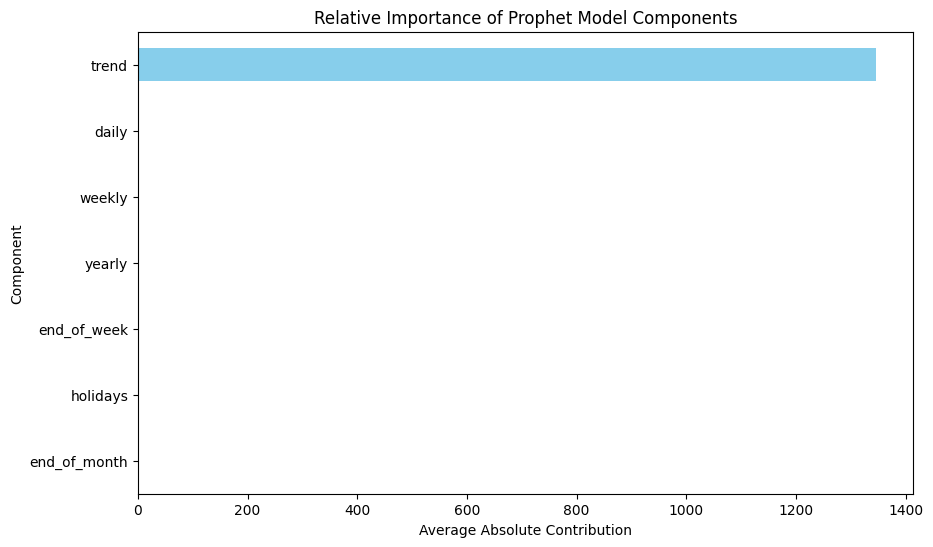

Mejor combinación de parámetros: {'growth': 'linear', 'changepoints': None, 'n_changepoints': 25, 'changepoint_range': 0.8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'holidays': None, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'changepoint_prior_scale': 0.5, 'mcmc_samples': 0, 'interval_width': 0.95, 'uncertainty_samples': 1000, 'stan_backend': None, 'country_holidays': 'UY'}
Mejor MSE: 432581.9405171393
Mejor RMSE: 657.7096171694157


In [95]:
import matplotlib.pyplot as plt

# Crear la nueva columna 'end_of_week' (1 si es domingo, 0 si no lo es)
df['ds'] = pd.to_datetime(df['ds'])
df['end_of_week'] = df['ds'].apply(lambda x: 1 if x.dayofweek == 6 else 0)
df['end_of_month'] = df['ds'].apply(lambda x: 1 if x.is_month_end else 0)

# Ejecutar la búsqueda de hiperparámetros
def prophet_grid_search(df, param_grid):
    # Lista para almacenar los resultados
    results = []
    
    # Generar todas las combinaciones posibles de los parámetros
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    
    # Iterar sobre cada combinación de parámetros
    for params in all_params:
        # Crear el modelo Prophet con los parámetros actuales
        m = Prophet(
            growth=params['growth'],
            changepoints=params['changepoints'],
            n_changepoints=params['n_changepoints'],
            changepoint_range=params['changepoint_range'],
            yearly_seasonality=params['yearly_seasonality'],
            weekly_seasonality=params['weekly_seasonality'],
            daily_seasonality=params['daily_seasonality'],
            holidays=params['holidays'],
            seasonality_mode=params['seasonality_mode'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'],
            changepoint_prior_scale=params['changepoint_prior_scale'],
            mcmc_samples=params['mcmc_samples'],
            interval_width=params['interval_width'],
            uncertainty_samples=params['uncertainty_samples'],
            stan_backend=params['stan_backend']
        )
        
        if params.get('country_holidays'):
            m.add_country_holidays(country_name=params['country_holidays'])
        
        # Agregar regresores
        m.add_regressor('end_of_week')
        m.add_regressor('end_of_month')

        # Entrenar el modelo
        m.fit(df)
        
        # Hacer predicciones
        future = m.make_future_dataframe(periods=60)

        # Agregar regresores al DataFrame 'future'
        future['end_of_week'] = future['ds'].apply(lambda x: 1 if x.dayofweek == 6 else 0)
        future['end_of_month'] = future['ds'].apply(lambda x: 1 if x.is_month_end else 0)

        # Realizar las predicciones
        forecast = m.predict(future)

        # Obtener y graficar la importancia de los componentes
        components = forecast[['trend', 'weekly', 'yearly', 'daily', 'holidays', 'end_of_week', 'end_of_month']]
        components_importance = components.abs().mean()
        components_importance

        # Calcular la importancia relativa de cada componente (media del valor absoluto)
        components_importance = components.abs().mean()

        # Ordenar los componentes de mayor a menor importancia
        components_sorted = components_importance.sort_values(ascending=False)

        # Crear el gráfico de barras con la importancia relativa de los componentes
        plt.figure(figsize=(10, 6))
        components_sorted.plot(kind='barh', color='skyblue')  # Gráfico de barras horizontal
        plt.title('Relative Importance of Prophet Model Components')
        plt.xlabel('Average Absolute Contribution')
        plt.ylabel('Component')
        plt.gca().invert_yaxis()  # Invertir el eje Y para que el más importante esté arriba
        plt.show()

        # Evaluar el modelo (MSE y RMSE)
        mse, rmse = evaluate_model(forecast['yhat'][:len(df)], df['y'])
        
        # Guardar los resultados (parámetros, MSE y RMSE)
        results.append((params, mse, rmse))
    
    # Ordenar los resultados por RMSE (menor es mejor)
    results = sorted(results, key=lambda x: x[2])  # Ordenar por RMSE
    
    # Mostrar la mejor combinación de parámetros
    best_params, best_mse, best_rmse = results[0]
    print(f"Mejor combinación de parámetros: {best_params}")
    print(f"Mejor MSE: {best_mse}")
    print(f"Mejor RMSE: {best_rmse}")
    
    return best_params, best_mse, best_rmse

# Ejecutar la búsqueda de hiperparámetros con el dataset
best_params, best_mse, best_rmse = prophet_grid_search(df, param_grid)
